In [23]:
import numpy as np
import pandas as pd

In [24]:
# Linear
class phi_1_1:
    def __init__(self):
        pass

    def compute(self, t, beta):
        return (1 - t) / 2

    def compute_2(self, t, beta):
        return -1 / 2


class phi_1_2:
    def __init__(self):
        pass

    def compute(self, t, beta):
        return (1 + t) / 2

    def compute_2(self, t, beta):
        return 1 / 2


# Streamline Upwind
class phi_1_1_su:
    def __init__(self):
        pass

    def compute(self, t, beta):
        return (1 - t) / 2 - beta / 2

    def compute_2(self, t, beta):
        return -1 / 2


class phi_1_2_su:
    def __init__(self):
        pass

    def compute(self, t, beta):
        return (t + 1) / 2 + beta / 2

    def compute_2(self, t, beta):
        return 1 / 2


# Bubble Functions
class phi_1_1_bb:
    def __init__(self):
        pass

    def compute(self, t, beta):
        return (1 - t) / 2 - 3 * beta(1 - t**2) / 4

    def compute_2(self, t, beta):
        return (3 / 2) * beta * t - (1 / 2)


class phi_1_2_bb:
    def __init__(self):
        pass

    def compute(self, t, beta):
        return (1 + t) / 2 + 3 * beta(1 - t**2) / 4

    def compute_2(self, t, beta):
        return -(3 / 2) * beta * t + (1 / 2)

In [25]:
def func_base_init(k, method="gk"):
    dict_phi = {}
    if k == 1:
        if method == "su":
            dict_phi[1] = phi_1_1_su()
            dict_phi[2] = phi_1_2_su()

        elif method == "bb":
            dict_phi[1] = phi_1_1_su()
            dict_phi[2] = phi_1_2_su()

        elif method == "gk" or method == "supg":
            dict_phi[1] = phi_1_1()
            dict_phi[2] = phi_1_2()

        else:
            print("Método não implementado")
            return 1

    else:
        print("Grau de polinômio não implementado")
        return 1

    return dict_phi

In [26]:
class quadratura:
    def __init__(self, k, h, beta) -> None:
        w = np.zeros(k + 1)
        t_GA = np.zeros(k + 1)
        self.h = h
        self.k = k
        self.beta = beta

        if k == 1:
            w[0] = 1
            w[1] = 1
            t_GA[0] = -1 / np.sqrt(3)
            t_GA[1] = 1 / np.sqrt(3)

        if k == 2:
            w[0] = 5 / 9
            w[1] = 8 / 9
            w[2] = 5 / 9
            t_GA[0] = -np.sqrt(3 / 5)
            t_GA[1] = 0
            t_GA[2] = np.sqrt(3 / 5)

        if k == 3:
            w[0] = (18 - np.sqrt(30)) / 36
            w[1] = (18 + np.sqrt(30)) / 36
            w[2] = (18 + np.sqrt(30)) / 36
            w[3] = (18 - np.sqrt(30)) / 36
            t_GA[0] = -np.sqrt(3 / 7 + (2 / 7) * np.sqrt(6 / 5))
            t_GA[1] = -np.sqrt(3 / 7 - (2 / 7) * np.sqrt(6 / 5))
            t_GA[2] = np.sqrt(3 / 7 - (2 / 7) * np.sqrt(6 / 5))
            t_GA[3] = np.sqrt(3 / 7 + (2 / 7) * np.sqrt(6 / 5))

        if k == 4:
            w[0] = (322 - 13 * np.sqrt(70)) / 900
            w[1] = (322 + 13 * np.sqrt(70)) / 900
            w[2] = 128 / 225
            w[3] = (322 + 13 * np.sqrt(70)) / 900
            w[4] = (322 - 13 * np.sqrt(70)) / 900
            t_GA[0] = -(1 / 3) * np.sqrt(5 + 2 * np.sqrt(10 / 7))
            t_GA[1] = -(1 / 3) * np.sqrt(5 - 2 * np.sqrt(10 / 7))
            t_GA[2] = 0
            t_GA[3] = (1 / 3) * np.sqrt(5 - 2 * np.sqrt(10 / 7))
            t_GA[4] = (1 / 3) * np.sqrt(5 + 2 * np.sqrt(10 / 7))

        self.w = w
        self.t_GA = t_GA

    def compute_m(self, j, phi1, phi2):
        poli_sum = 0

        for w, t in zip(self.w, self.t_GA):
            poli_sum += (
                w
                * j.compute(t)
                * phi1.compute(t, self.beta)
                * phi2.compute(t, self.beta)
                * (self.h / 2)
            )

        return poli_sum

    def compute_k(self, k, phi1, phi2):
        poli_sum = 0

        for w, t in zip(self.w, self.t_GA):
            poli_sum += (
                w
                * k.compute(t)
                * phi1.compute_2(t, self.beta)
                * phi2.compute_2(t, self.beta)
                * 2
                / self.h
            )

        return poli_sum

    def compute_c(self, l, phi1, phi2):
        poli_sum = 0

        for w, t in zip(self.w, self.t_GA):
            poli_sum += (
                w
                * l.compute(t)
                * phi1.compute_2(t, self.beta)
                * phi2.compute(t, self.beta)
            )

        return poli_sum

    def compute_g(self, g, phi2):
        poli_sum = 0

        for w, t in zip(self.w, self.t_GA):
            poli_sum += w * g.compute(t) * phi2.compute(t, self.beta) * (self.h / 2)

        return poli_sum

    def compute_tau(self, g, phi2):
        poli_sum = 0

        for w, t in zip(self.w, self.t_GA):
            poli_sum += w * g.compute(t) * phi2.compute_2(t, self.beta) * (self.h / 2)

        return poli_sum

    def compute_l2(self, g, shg, alpha, xl, index):
        poli_sum = 0
        nen = self.k + 1

        for w, t in zip(self.w, self.t_GA):
            uh = 0
            xx = 0

            for i in range(nen):
                phi = shg[i + 1]
                uh += phi.compute(t,self.beta) * alpha[index + i][0]
                xx += phi.compute(t,self.beta) * xl[index + i]

            poli_sum += ((g.compute_real(xx) - uh) ** 2) * w * (self.h / 2)

        return poli_sum

    def compute_dif_l2(self, g, shg, alpha, xl, index):
        poli_sum = 0
        nen = self.k + 1

        for w, t in zip(self.w, self.t_GA):
            duh = 0
            xx = 0

            for i in range(nen):
                phi = shg[i + 1]
                duh += phi.compute_2(t,self.beta) * (2 / self.h) * alpha[index + i][0]
                xx += phi.compute(t,self.beta) * xl[index + i]

            poli_sum += ((g.compute_dif_real(xx) - duh) ** 2) * w * (self.h / 2)

        return poli_sum


class f_el_ref:
    def __init__(self, a, b, kappa, epsilon) -> None:
        self.a = a
        self.b = b
        self.kappa = kappa
        self.epsilon = epsilon

    def u(self, x):
        return (1 / self.kappa) * (
            x
            - (1 - np.exp(self.kappa * x / self.epsilon))
            / (1 - np.exp(self.kappa / self.epsilon))
        )

    def df(self, x):
        return 1

    def df_1(self, x):
        return 0

    def k(self, x):
        return 1

    def j(self, x):
        return 0

    def l(self, x):
        return 1

    def x_t(self, t):
        return (self.b - self.a) / 2 * t + (self.b + self.a) / 2

    def compute(self, t):
        return self.df(self.x_t(t))

    def compute_real(self, t):
        return self.u(t)

    def compute_dif_real(self, t):
        return self.df_1(t)


class k_el_ref(f_el_ref):
    def __init__(self, a, b, kappa, epsilon) -> None:
        self.a = a
        self.b = b
        self.kappa = kappa
        self.epsilon = epsilon

    def compute(self, t):
        return self.k(self.x_t(t))


class j_el_ref(f_el_ref):
    def __init__(self, a, b, kappa, epsilon) -> None:
        self.a = a
        self.b = b
        self.kappa = kappa
        self.epsilon = epsilon

    def compute(self, t):
        return self.j(self.x_t(t))


class l_el_ref(f_el_ref):
    def __init__(self, a, b, kappa, epsilon) -> None:
        self.a = a
        self.b = b
        self.kappa = kappa
        self.epsilon = epsilon

    def compute(self, t):
        return self.l(self.x_t(t))

In [27]:
def FEM(
    a,
    b,
    nel,
    k,
    kapa_a,
    kapa_b,
    g_a,
    g_b,
    q_a,
    q_b,
    kappa,
    epsilon,
    method="gk",
):
    # dimensão do elemento
    h = (b - a) / nel

    Peh = (kappa * h) / (2 * epsilon)
    beta = 1 / np.tanh(Peh) - 1 / Peh
    tau = (beta * h) /( 2 * kappa)

    # inicializando quadratura de gauss
    QG = quadratura(k, h, beta)

    # num total de nós da malha
    nn = k * nel + 1

    # num de nós do elem.
    nen = k + 1

    # vetor de de posições dos nós
    xl = np.array([a + h * i / k for i in range(nn)])

    # matriz global
    M = np.zeros((nn, nn))
    K = np.zeros((nn, nn))
    C = np.zeros((nn, nn))
    F = np.zeros((nn, 1))

    # montagem do problema global
    for n in range(nel):
        Me = np.zeros((nen, nen))
        Ke = np.zeros((nen, nen))
        Ce = np.zeros((nen, nen))
        Fe = np.zeros((nen))
        shg = func_base_init(k, method=method)

        # Encontrando pontos de integração
        x0 = a + n * h
        x1 = a + (n + 1) * h

        # definindo G(t)
        g_t = f_el_ref(x0, x1, kappa, epsilon)

        # definindo K(t)
        k_t = k_el_ref(x0, x1, kappa, epsilon)

        # definindo J(t)
        j_t = j_el_ref(x0, x1, kappa, epsilon)

        # definindo L(t)
        l_t = l_el_ref(x0, x1, kappa, epsilon)

        if method == "supg":
            for i in range(nen):
                # calculando matriz de carga local
                Fe[i] = QG.compute_g(g_t, shg[i + 1]) + tau * kappa * QG.compute_tau(
                    g_t, shg[i + 1]
                )
                for j in range(nen):
                    # calculando matriz de massa local
                    Me[i, j] = QG.compute_m(j_t, shg[i + 1], shg[j + 1])
                    # calculando matriz de rigidez local
                    Ke[i, j] = QG.compute_k(k_t, shg[i + 1], shg[j + 1]) * (
                        epsilon + tau * (kappa**2)
                    )
                    # calculando matriz de amortecimento local
                    Ce[i, j] = QG.compute_c(l_t, shg[j + 1], shg[i + 1]) * kappa

        else:
            for i in range(nen):
                # calculando matriz de carga local
                Fe[i] = QG.compute_g(g_t, shg[i + 1])
                for j in range(nen):
                    # calculando matriz de massa local
                    Me[i, j] = QG.compute_m(j_t, shg[i + 1], shg[j + 1])
                    # calculando matriz de rigidez local
                    Ke[i, j] = QG.compute_k(k_t, shg[i + 1], shg[j + 1]) * epsilon
                    # calculando matriz de amortecimento local
                    Ce[i, j] = QG.compute_c(l_t, shg[j + 1], shg[i + 1]) * kappa

        for i in range(nen):
            # Preenchendo matriz de carga global
            if n != 0 and i == 0:
                F[n * k + i] += Fe[i]

            else:
                F[n * k + i] = Fe[i]

            for j in range(nen):
                if i == 0 and j == 0:
                    # Preenchendo matriz de massa global
                    M[n * k + i, n * k + j] += Me[i, j]
                    # Preenchendo matriz de rigidez global
                    K[n * k + i, n * k + j] += Ke[i, j]
                    # Preenchendo matriz de amortecimento global
                    C[n * k + i, n * k + j] += Ce[i, j]
                else:
                    # Preenchendo matriz de massa global
                    M[n * k + i, n * k + j] = Me[i, j]
                    # Preenchendo matriz de rigidez global
                    K[n * k + i, n * k + j] = Ke[i, j]
                    # Preenchendo matriz de amortecimento global
                    C[n * k + i, n * k + j] = Ce[i, j]

    # Aplicando condições de contorno
    K[0, 0] += kapa_a
    K[nn - 1, nn - 1] += kapa_b
    F[0] += kapa_a * g_a - q_a
    F[nn - 1] += kapa_b * g_b - q_b

    # Resolvendo sistema
    alpha = np.linalg.solve((K + M + C), F)

    # erro da norma L2
    l_2_error = 0
    index = 0
    for n in range(nel):
        l_2_error += QG.compute_l2(g_t, shg, alpha, xl, index)

        index += k

    l_2_error = np.sqrt(l_2_error)

    # erro da norma L2 da derivada
    l_2_dif_error = 0
    index = 0
    for n in range(nel):
        l_2_dif_error += QG.compute_dif_l2(g_t, shg, alpha, xl, index)

        index += k

    l_2_dif_error = np.sqrt(l_2_dif_error)

    return h, xl, alpha, l_2_error, l_2_dif_error

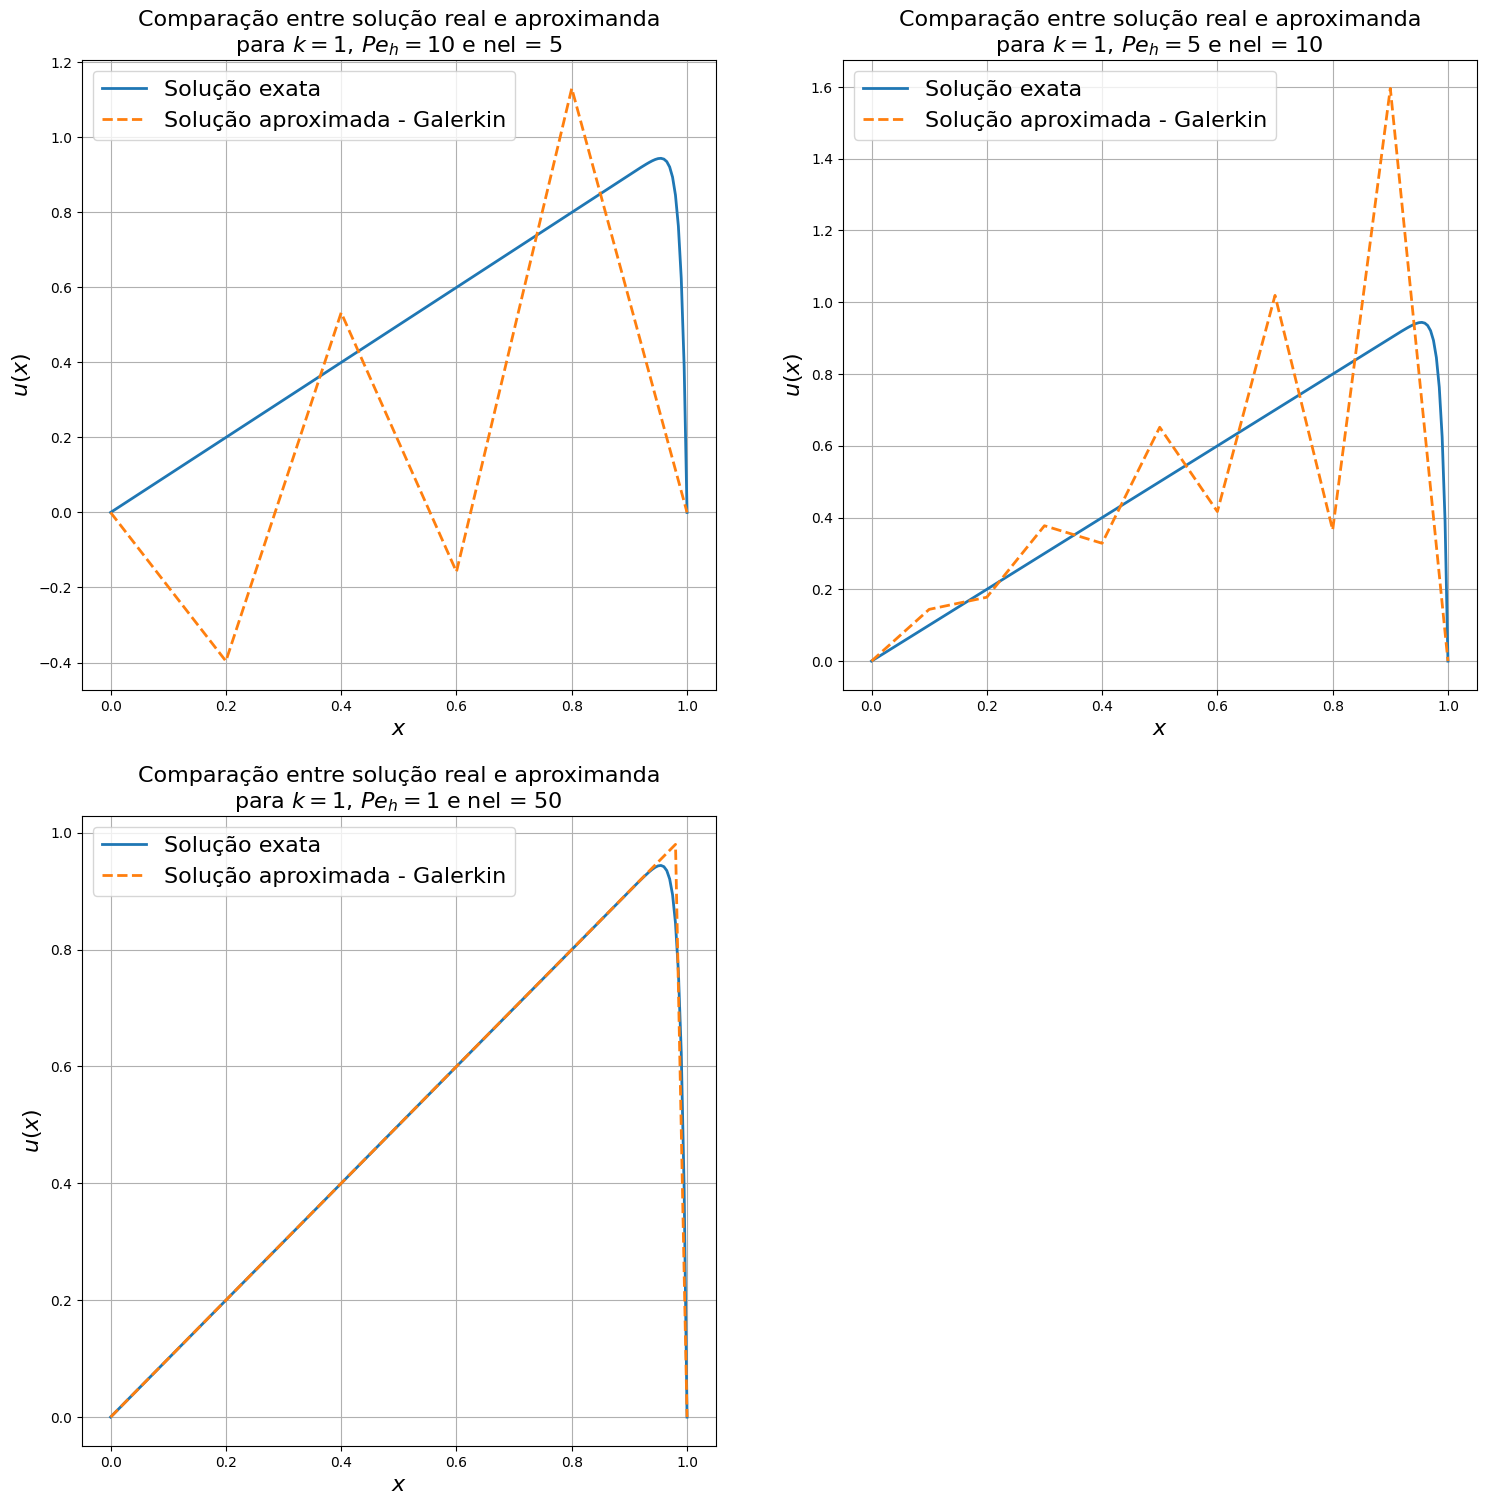

In [28]:
import matplotlib.pyplot as plt


def u(x, kappa, epsilon):
    return (1 / kappa) * (
        x - (1 - np.exp(kappa * x / epsilon)) / (1 - np.exp(kappa / epsilon))
    )


a = 0
b = 1

kappa = 1

epsilon = 1e-2

k_list = [1]

Peh_list = [10, 5, 1]

nel_list = [int((1 / (2 * epsilon)) * (b - a) / Peh) for Peh in Peh_list]

kappa_dr_a = 10**6
kappa_dr_b = 10**6
g_a = g_b = 0
q_a = q_b = 0

size = 2

result_dict = {}

for k in k_list:
    plot_count = 1

    fig = plt.figure(figsize=[size * 9, size * 9])

    result_dict["base_" + str(k)] = {"erro": [], "erro_dif": [], "h": []}

    for nel, Peh in zip(nel_list, Peh_list):
        # Realizando a Projeção

        # Plotando resultados
        ax = fig.add_subplot(2, 2, plot_count)

        ax.set_title(
            "Comparação entre solução real e aproximanda\npara $k = {}$, $Pe_h = {}$ e nel = {}".format(
                k, Peh, nel
            ),
            fontsize=16,
        )

        ax.set_ylabel("$u(x)$", fontsize=16)
        ax.set_xlabel("$x$", fontsize=16)

        # função real

        x_eval = np.linspace(a, b, num=200)

        ax.plot(
            x_eval,
            u(x_eval, kappa, epsilon),
            linewidth=2,
            label="Solução exata",
        )

        h, xl, alpha, l_2_error, l_2_dif_error = FEM(
            a,
            b,
            nel,
            k,
            kappa_dr_a,
            kappa_dr_b,
            g_a,
            g_b,
            q_a,
            q_b,
            kappa,
            epsilon,
            method="gk",
        )

        result_dict["base_" + str(k)]["erro"].append(l_2_error)
        result_dict["base_" + str(k)]["erro_dif"].append(l_2_dif_error)
        result_dict["base_" + str(k)]["h"].append(h)

        ax.plot(xl, alpha, linestyle="--", linewidth=2, label="Solução aproximada - Galerkin")

        ax.legend(fontsize=16)

        ax.grid()

        plot_count += 1

    plt.show()
    fig.savefig("figures/real_vs_mef_k_{}_q1_b.png".format(k))

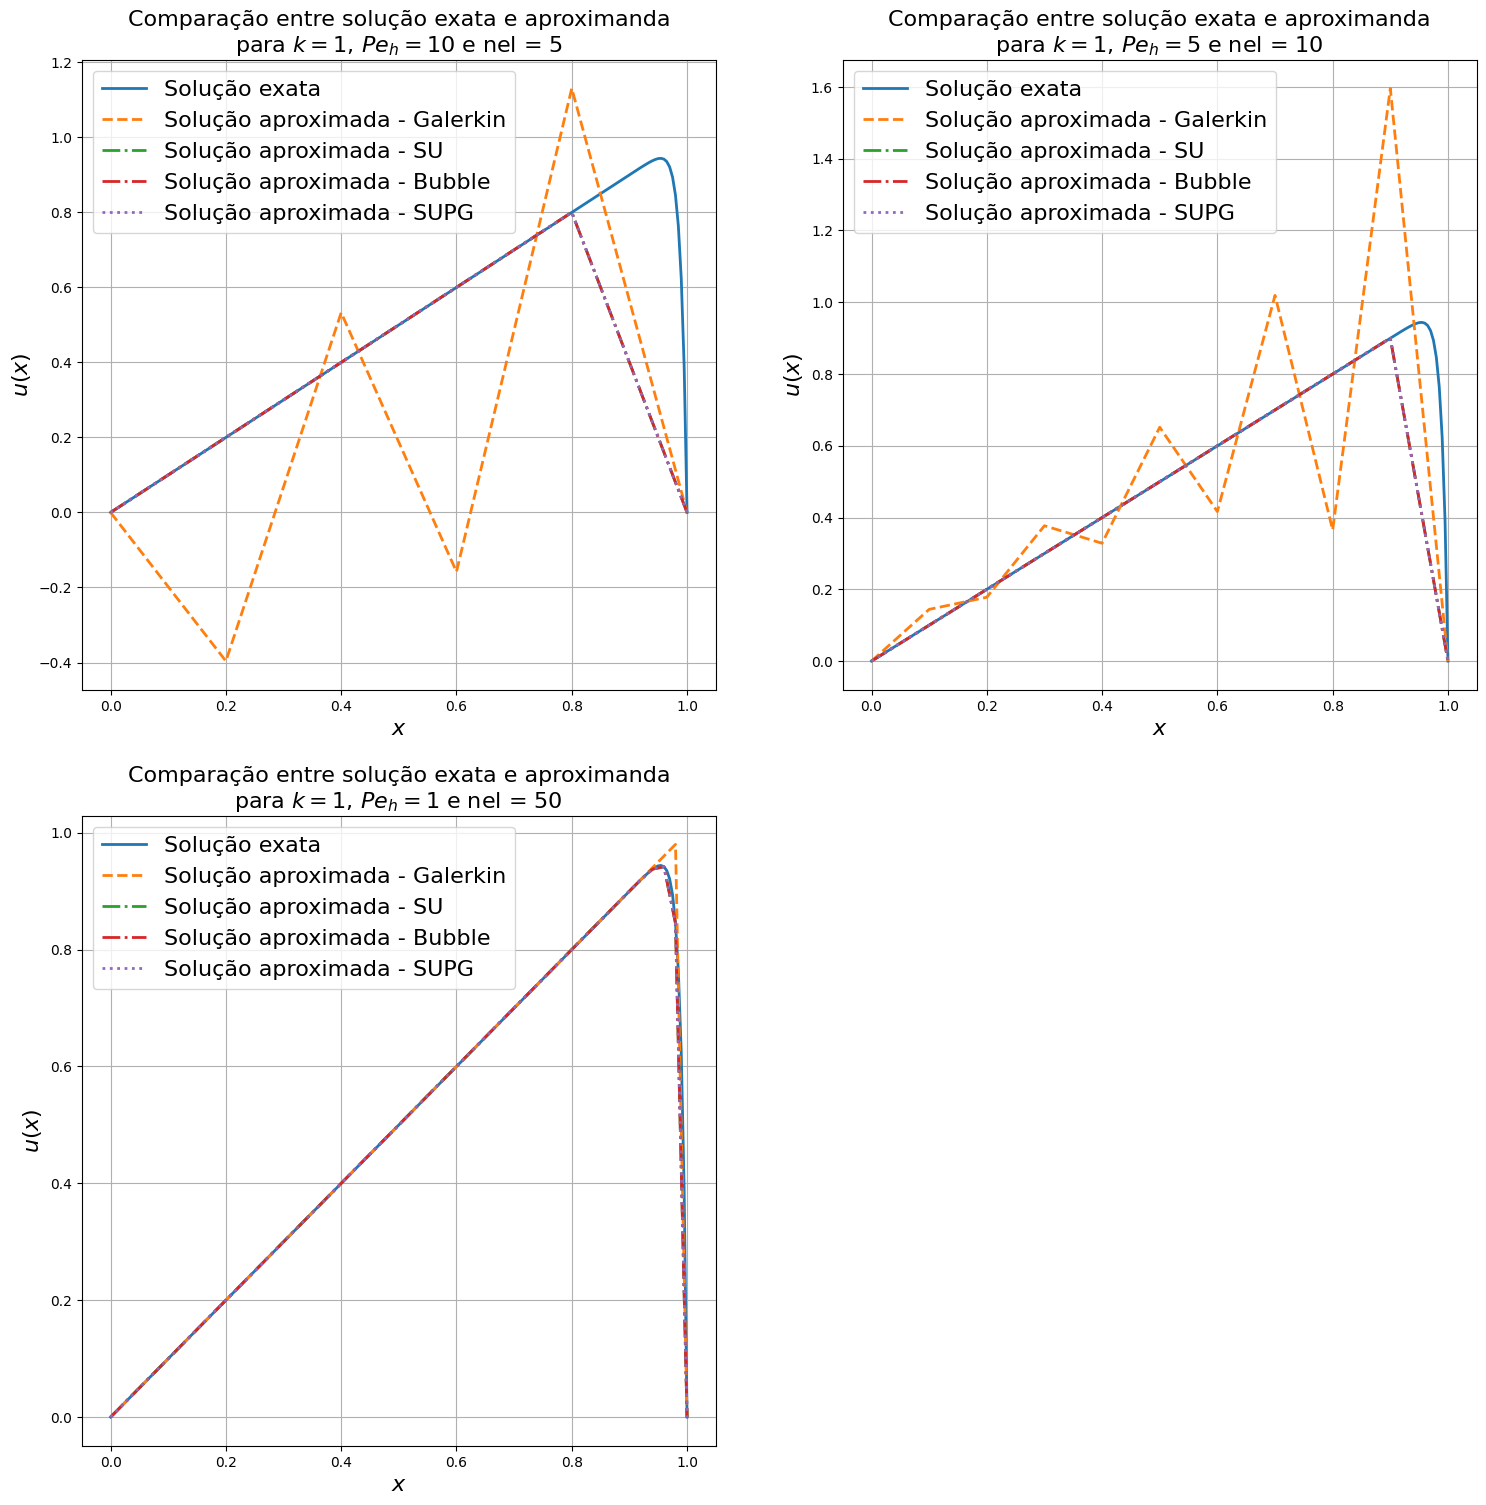

In [29]:
import matplotlib.pyplot as plt


def u(x, kappa, epsilon):
    return (1 / kappa) * (
        x - (1 - np.exp(kappa * x / epsilon)) / (1 - np.exp(kappa / epsilon))
    )


a = 0
b = 1

kappa = 1

epsilon = 1e-2

k_list = [1]

Peh_list = [10, 5, 1]

nel_list = [int((1 / (2 * epsilon)) * (b - a) / Peh) for Peh in Peh_list]

kappa_dr_a = 10**6
kappa_dr_b = 10**6
g_a = g_b = 0
q_a = q_b = 0

size = 2

result_dict = {}

for k in k_list:
    plot_count = 1

    fig = plt.figure(figsize=[size * 9, size * 9])

    result_dict["base_" + str(k)] = {"erro": [], "erro_dif": [], "h": []}

    for nel, Peh in zip(nel_list, Peh_list):
        # Realizando a Projeção

        # Plotando resultados
        ax = fig.add_subplot(2, 2, plot_count)

        ax.set_title(
            "Comparação entre solução exata e aproximanda\npara $k = {}$, $Pe_h = {}$ e nel = {}".format(
                k, Peh, nel
            ),
            fontsize=16,
        )

        ax.set_ylabel("$u(x)$", fontsize=16)
        ax.set_xlabel("$x$", fontsize=16)

        # solução exata

        x_eval = np.linspace(a, b, num=200)

        ax.plot(
            x_eval,
            u(x_eval, kappa, epsilon),
            linewidth=2,
            label="Solução exata",
        )

        h, xl, alpha, l_2_error, l_2_dif_error = FEM(
            a,
            b,
            nel,
            k,
            kappa_dr_a,
            kappa_dr_b,
            g_a,
            g_b,
            q_a,
            q_b,
            kappa,
            epsilon,
            method="gk",
        )

        result_dict["base_" + str(k)]["erro"].append(l_2_error)
        result_dict["base_" + str(k)]["erro_dif"].append(l_2_dif_error)
        result_dict["base_" + str(k)]["h"].append(h)

        ax.plot(xl, alpha, linestyle="--", linewidth=2, label="Solução aproximada - Galerkin")

        h, xl, alpha, l_2_error, l_2_dif_error = FEM(
            a,
            b,
            nel,
            k,
            kappa_dr_a,
            kappa_dr_b,
            g_a,
            g_b,
            q_a,
            q_b,
            kappa,
            epsilon,
            method="su",
        )

        result_dict["base_" + str(k)]["erro"].append(l_2_error)
        result_dict["base_" + str(k)]["erro_dif"].append(l_2_dif_error)
        result_dict["base_" + str(k)]["h"].append(h)

        ax.plot(xl, alpha, linestyle="-.", linewidth=2, label="Solução aproximada - SU")

        h, xl, alpha, l_2_error, l_2_dif_error = FEM(
            a,
            b,
            nel,
            k,
            kappa_dr_a,
            kappa_dr_b,
            g_a,
            g_b,
            q_a,
            q_b,
            kappa,
            epsilon,
            method="bb",
        )

        result_dict["base_" + str(k)]["erro"].append(l_2_error)
        result_dict["base_" + str(k)]["erro_dif"].append(l_2_dif_error)
        result_dict["base_" + str(k)]["h"].append(h)

        ax.plot(xl, alpha, linestyle="-.", linewidth=2, label="Solução aproximada - Bubble")

        h, xl, alpha, l_2_error, l_2_dif_error = FEM(
            a,
            b,
            nel,
            k,
            kappa_dr_a,
            kappa_dr_b,
            g_a,
            g_b,
            q_a,
            q_b,
            kappa,
            epsilon,
            method="supg",
        )

        result_dict["base_" + str(k)]["erro"].append(l_2_error)
        result_dict["base_" + str(k)]["erro_dif"].append(l_2_dif_error)
        result_dict["base_" + str(k)]["h"].append(h)

        ax.plot(xl, alpha, linestyle=":", linewidth=2, label="Solução aproximada - SUPG")

        ax.legend(fontsize=16)

        ax.grid()

        plot_count += 1

    plt.show()
    fig.savefig("figures/real_vs_mef_k_{}_q1_c.png".format(k))